In [19]:
import os
import shutil
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50, VGG16, EfficientNetB0
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# --- CONFIG ---
round3_base_path = r'C:\Users\gajje\OneDrive\Desktop\Major\Lung_diagnosis_files\Dataset\Dataset\Dataset\round-3'
percent_folder = '50'

base_percent_path = os.path.join(round3_base_path, percent_folder)
level1_path = os.path.join(base_percent_path, 'Level1', '10%Base')
level2_path = os.path.join(base_percent_path, 'Level2', 'Inbox')
level3_path = os.path.join(base_percent_path, 'Level3', 'Outbox')
training_root = os.path.join(base_percent_path, 'Training')
training_paths = [os.path.join(training_root, sub) for sub in ['90%Base', 'Th1', 'Th2', 'Th3']]

r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir = [f'round3_{percent_folder}/{x}' for x in ['train', 'test1', 'test2', 'test3']]
for folder in [r3_train_dir, r3_test1_dir, r3_test2_dir, r3_test3_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

def split_and_copy(src_folder, dst_folder):
    labels = os.listdir(src_folder)
    for label in labels:
        src_label_path = os.path.join(src_folder, label)
        dst_label_path = os.path.join(dst_folder, label)
        os.makedirs(dst_label_path, exist_ok=True)
        files = [f for f in os.listdir(src_label_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for f in files:
            shutil.copy(os.path.join(src_label_path, f), os.path.join(dst_label_path, f))

for path in training_paths:
    split_and_copy(path, r3_train_dir)
split_and_copy(level1_path, r3_test1_dir)
split_and_copy(level2_path, r3_test2_dir)
split_and_copy(level3_path, r3_test3_dir)

# --- IMAGE DATA ---
img_size = (128, 128)
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(r3_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_data = {
    'Level1': datagen.flow_from_directory(r3_test1_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False),
    'Level2': datagen.flow_from_directory(r3_test2_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False),
    'Level3': datagen.flow_from_directory(r3_test3_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
}


Found 1555 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Found 534 images belonging to 3 classes.
Found 648 images belonging to 3 classes.


In [21]:
# --- MODEL DEFINITIONS ---
def build_custom_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def build_model(base_model):
    base = base_model(include_top=False, weights='imagenet', input_shape=(128,128,3))
    base.trainable = False
    model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def build_alexnet():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(96, (11,11), strides=4, activation='relu', input_shape=(128,128,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2),
        tf.keras.layers.Conv2D(256, (5,5), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2),
        tf.keras.layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(384, (3,3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model



In [22]:
model_builders = {
    "CustomCNN": build_custom_cnn,
    "MobileNetV2": lambda: build_model(MobileNetV2),
    "ResNet50": lambda: build_model(ResNet50),
    "VGG16": lambda: build_model(VGG16),
    "EfficientNetB0": lambda: build_model(EfficientNetB0),
    "AlexNet": build_alexnet
}



========== Training CustomCNN ==========
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.3818 - loss: 1.4219 - val_accuracy: 0.3694 - val_loss: 1.0999
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.3638 - loss: 1.0970 - val_accuracy: 0.3376 - val_loss: 1.1210
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.3839 - loss: 1.0862 - val_accuracy: 0.3376 - val_loss: 1.0984
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 300ms/step - accuracy: 0.3653 - loss: 1.0937 - val_accuracy: 0.3376 - val_loss: 1.0773
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step - accuracy: 0.3859 - loss: 1.0543 - val_accuracy: 0.4777 - val_loss: 1.0002
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 266ms/step - accuracy: 0.4431 - loss: 0.9877 - val_accuracy: 0.6051 - val_loss: 0.9543
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 158ms/step - accuracy: 0.6085 - loss: 0.9113 - val_accuracy: 0.5987 - val_loss: 0.8875
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - 

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

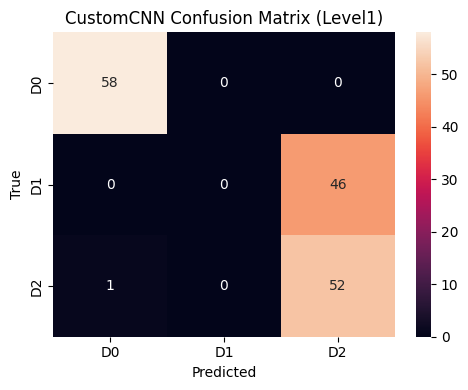

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step

CustomCNN Accuracy on Level2: 64.04%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.90      1.00      0.95       174
          D1       0.00      0.00      0.00       180
          D2       0.49      0.93      0.64       180

    accuracy                           0.64       534
   macro avg       0.46      0.64      0.53       534
weighted avg       0.46      0.64      0.53       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

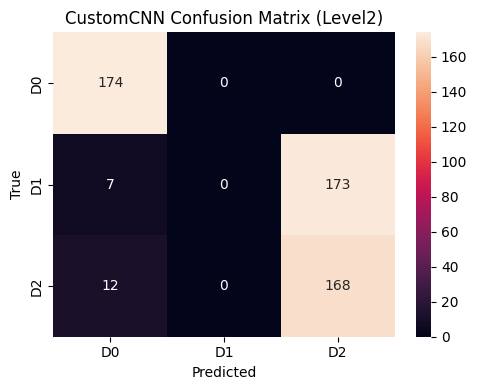

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

CustomCNN Accuracy on Level3: 71.76%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.84      0.99      0.91       252
          D1       0.00      0.00      0.00       144
          D2       0.62      0.86      0.72       252

    accuracy                           0.72       648
   macro avg       0.48      0.62      0.54       648
weighted avg       0.56      0.72      0.63       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

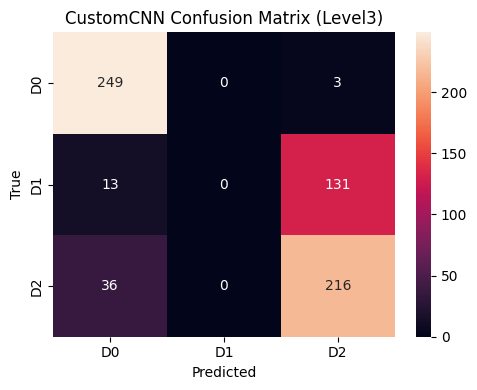


CustomCNN Overall Accuracy: 68.48%

========== Training MobileNetV2 ==========
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 47s 409ms/step - accuracy: 0.3589 - loss: 1.3706 - val_accuracy: 0.5032 - val_loss: 0.9829
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.5148 - loss: 0.9979 - val_accuracy: 0.4204 - val_loss: 1.0449
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.4977 - loss: 0.9860 - val_accuracy: 0.5159 - val_loss: 0.9980
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.5211 - loss: 0.9657 - val_accuracy: 0.5414 - val_loss: 0.9145
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.5782 - loss: 0.9142 - val_accuracy: 0.5414 - val_loss: 0.9742
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy: 0.5648 - loss: 0.9094 - val_accuracy: 0.5159 - val_loss: 0.8913
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.5803 - loss: 0.8908 - val_accuracy: 0.5669 - val_loss: 0.8619
Epoch 8/10
98/98 

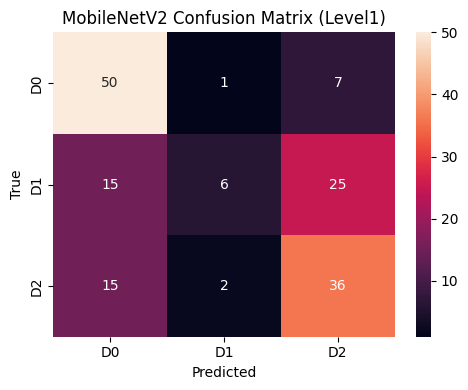

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step

MobileNetV2 Accuracy on Level2: 48.88%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.53      0.76      0.62       174
          D1       0.44      0.11      0.17       180
          D2       0.46      0.61      0.52       180

    accuracy                           0.49       534
   macro avg       0.48      0.49      0.44       534
weighted avg       0.47      0.49      0.44       534



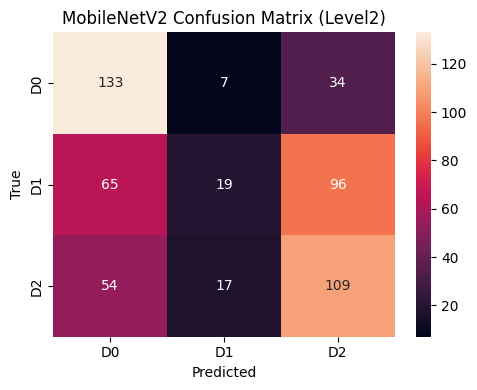

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 313ms/step

MobileNetV2 Accuracy on Level3: 63.58%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.63      0.90      0.74       252
          D1       0.50      0.15      0.23       144
          D2       0.66      0.65      0.66       252

    accuracy                           0.64       648
   macro avg       0.60      0.57      0.54       648
weighted avg       0.61      0.64      0.59       648



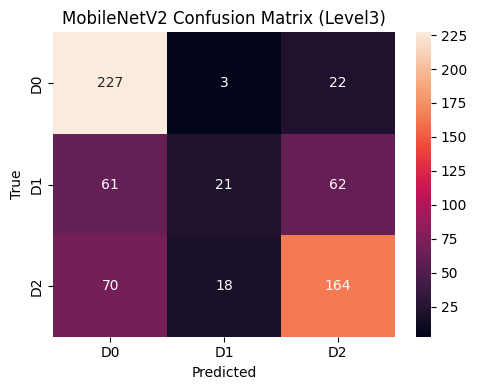


MobileNetV2 Overall Accuracy: 57.13%

========== Training ResNet50 ==========
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 57s 501ms/step - accuracy: 0.3338 - loss: 1.1168 - val_accuracy: 0.3376 - val_loss: 1.1397
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 36s 363ms/step - accuracy: 0.4075 - loss: 1.0870 - val_accuracy: 0.4140 - val_loss: 1.0901
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.3824 - loss: 1.0875 - val_accuracy: 0.3758 - val_loss: 1.0921
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.3997 - loss: 1.0807 - val_accuracy: 0.4459 - val_loss: 1.0992
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 57s 580ms/step - accuracy: 0.4100 - loss: 1.0734 - val_accuracy: 0.4904 - val_loss: 1.1073
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 62s 626ms/step - accuracy: 0.3886 - loss: 1.0822 - val_accuracy: 0.3822 - val_loss: 1.0831
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.4105 - loss: 1.0726 - val_accuracy: 0.3376 - val_loss: 1.1323
Epoch 8/10
98/98 ━

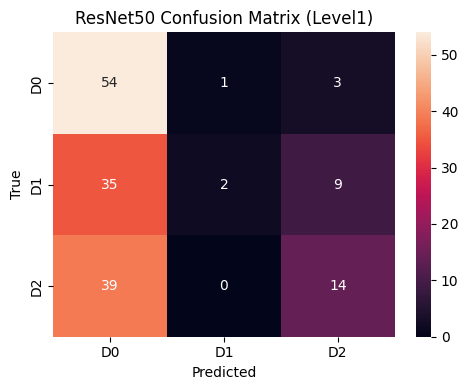

34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 660ms/step

ResNet50 Accuracy on Level2: 40.07%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.39      0.86      0.53       174
          D1       0.50      0.02      0.04       180
          D2       0.44      0.34      0.38       180

    accuracy                           0.40       534
   macro avg       0.44      0.41      0.32       534
weighted avg       0.44      0.40      0.32       534



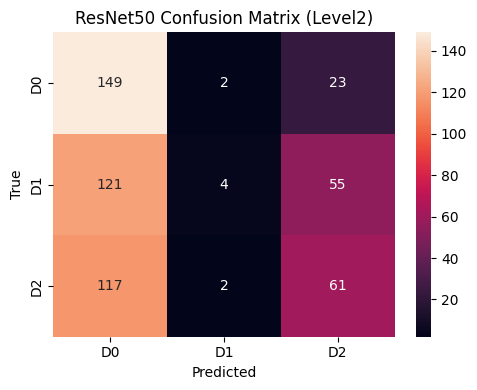

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step

ResNet50 Accuracy on Level3: 50.77%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.47      0.94      0.63       252
          D1       0.50      0.01      0.01       144
          D2       0.63      0.36      0.46       252

    accuracy                           0.51       648
   macro avg       0.53      0.44      0.37       648
weighted avg       0.54      0.51      0.43       648



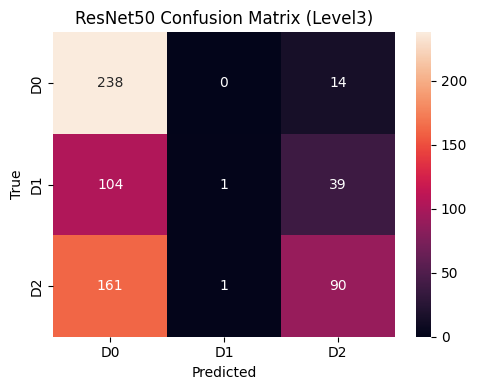


ResNet50 Overall Accuracy: 45.78%

========== Training VGG16 ==========
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 801ms/step - accuracy: 0.3509 - loss: 1.1086 - val_accuracy: 0.3312 - val_loss: 1.0978
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.3656 - loss: 1.0915 - val_accuracy: 0.5032 - val_loss: 1.0559
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 813ms/step - accuracy: 0.4464 - loss: 1.0638 - val_accuracy: 0.5287 - val_loss: 1.0483
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.4834 - loss: 1.0474 - val_accuracy: 0.5287 - val_loss: 1.0127
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.4652 - loss: 1.0381 - val_accuracy: 0.5287 - val_loss: 1.0070
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5153 - loss: 1.0135 - val_accuracy: 0.4395 - val_loss: 1.0013
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 91s 924ms/step - accuracy: 0.4899 - loss: 1.0091 - val_accuracy: 0.5096 - val_loss: 1.0091
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━

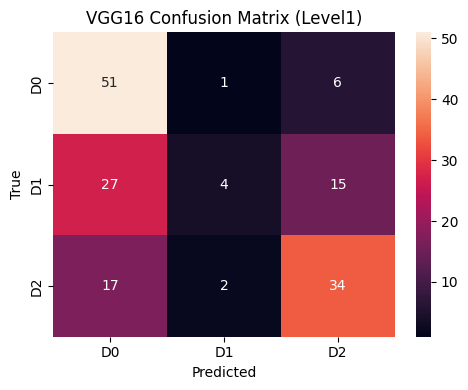

34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 954ms/step

VGG16 Accuracy on Level2: 44.19%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.43      0.78      0.55       174
          D1       0.49      0.10      0.17       180
          D2       0.46      0.46      0.46       180

    accuracy                           0.44       534
   macro avg       0.46      0.45      0.39       534
weighted avg       0.46      0.44      0.39       534



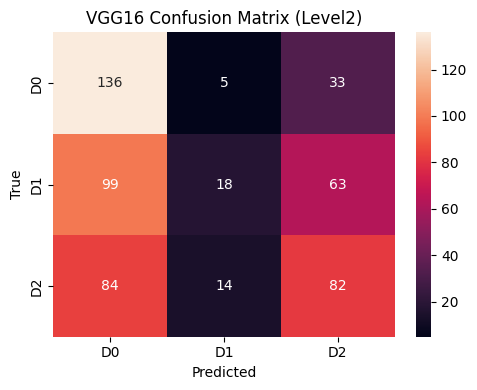

41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step

VGG16 Accuracy on Level3: 59.72%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.55      0.92      0.69       252
          D1       0.44      0.03      0.05       144
          D2       0.69      0.60      0.64       252

    accuracy                           0.60       648
   macro avg       0.56      0.52      0.46       648
weighted avg       0.58      0.60      0.53       648



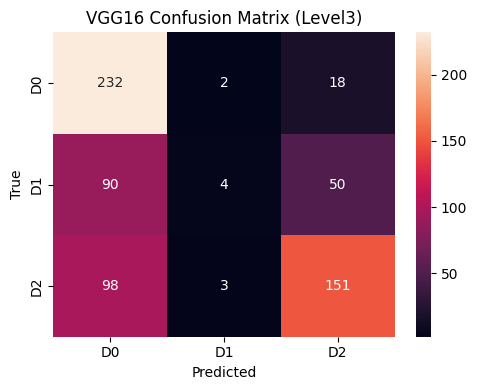


VGG16 Overall Accuracy: 53.17%

========== Training EfficientNetB0 ==========
Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 491ms/step - accuracy: 0.3683 - loss: 1.1172 - val_accuracy: 0.3376 - val_loss: 1.1024
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 514ms/step - accuracy: 0.3805 - loss: 1.0948 - val_accuracy: 0.3376 - val_loss: 1.1050
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.3606 - loss: 1.0993 - val_accuracy: 0.3694 - val_loss: 1.1116
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 240ms/step - accuracy: 0.3767 - loss: 1.0847 - val_accuracy: 0.3694 - val_loss: 1.0993
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.3410 - loss: 1.0950 - val_accuracy: 0.3694 - val_loss: 1.1023
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.3801 - loss: 1.0874 - val_accuracy: 0.3376 - val_loss: 1.0964
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.3568 - loss: 1.0966 - val_accuracy: 0.3694 - val_loss: 1.1095
Epoch 8/10
98/98 ━

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

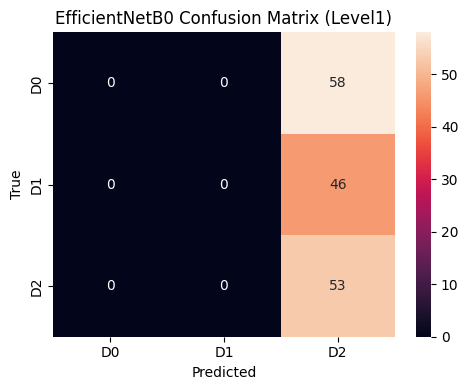

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 342ms/step

EfficientNetB0 Accuracy on Level2: 33.71%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.00      0.00      0.00       174
          D1       0.00      0.00      0.00       180
          D2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

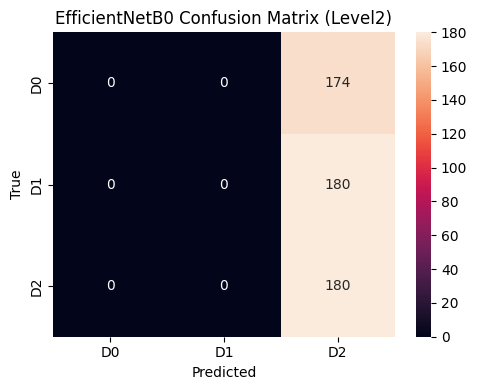

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step

EfficientNetB0 Accuracy on Level3: 38.89%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.00      0.00      0.00       252
          D1       0.00      0.00      0.00       144
          D2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

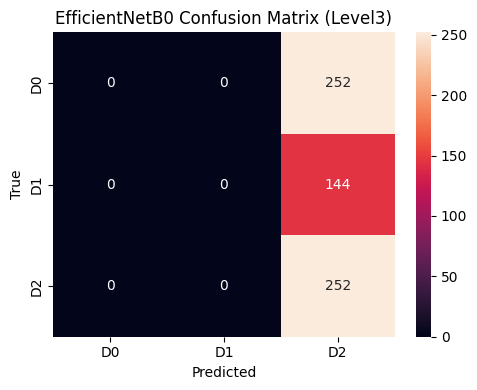


EfficientNetB0 Overall Accuracy: 36.22%

========== Training AlexNet ==========


C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 58s 492ms/step - accuracy: 0.3637 - loss: 1.3548 - val_accuracy: 0.3376 - val_loss: 1.1005
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 49s 500ms/step - accuracy: 0.3652 - loss: 1.0904 - val_accuracy: 0.3376 - val_loss: 1.0996
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 450ms/step - accuracy: 0.3973 - loss: 1.0787 - val_accuracy: 0.3694 - val_loss: 1.0946
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 46s 470ms/step - accuracy: 0.3652 - loss: 1.0876 - val_accuracy: 0.3376 - val_loss: 1.1007
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 447ms/step - accuracy: 0.3719 - loss: 1.0846 - val_accuracy: 0.3376 - val_loss: 1.0953
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 37s 373ms/step - accuracy: 0.3383 - loss: 1.0910 - val_accuracy: 0.3376 - val_loss: 1.1014
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - accuracy: 0.3912 - loss: 1.0825 - val_accuracy: 0.3376 - val_loss: 1.0973
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - accuracy: 0.3633 - loss: 1.0858 - val_accu

C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

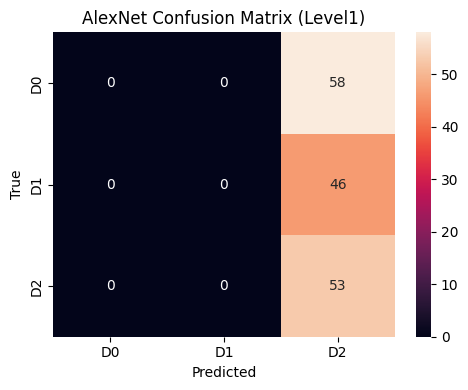

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step

AlexNet Accuracy on Level2: 33.71%

Classification Report (Level2):
               precision    recall  f1-score   support

          D0       0.00      0.00      0.00       174
          D1       0.00      0.00      0.00       180
          D2       0.34      1.00      0.50       180

    accuracy                           0.34       534
   macro avg       0.11      0.33      0.17       534
weighted avg       0.11      0.34      0.17       534



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

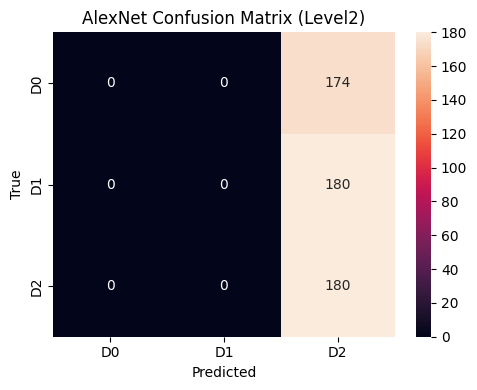

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step

AlexNet Accuracy on Level3: 38.89%

Classification Report (Level3):
               precision    recall  f1-score   support

          D0       0.00      0.00      0.00       252
          D1       0.00      0.00      0.00       144
          D2       0.39      1.00      0.56       252

    accuracy                           0.39       648
   macro avg       0.13      0.33      0.19       648
weighted avg       0.15      0.39      0.22       648



C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gajje\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

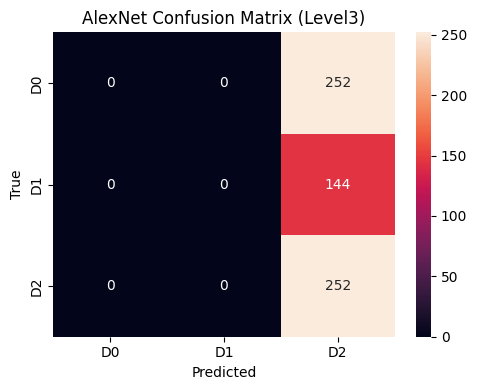


AlexNet Overall Accuracy: 36.22%


In [23]:
# --- TRAIN & EVALUATE ---
for name, builder in model_builders.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    model = builder()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, epochs=10, validation_data=test_data['Level1'])

    all_preds = []
    all_labels = []
    total_correct = 0
    total_samples = 0

    for level_name, data in test_data.items():
        preds = model.predict(data)
        y_pred = np.argmax(preds, axis=1)
        y_true = data.classes

        acc = accuracy_score(y_true, y_pred)
        print(f"\n{name} Accuracy on {level_name}: {acc*100:.2f}%")

        print(f"\nClassification Report ({level_name}):\n", classification_report(y_true, y_pred, target_names=list(data.class_indices.keys())))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=data.class_indices, yticklabels=data.class_indices)
        plt.title(f"{name} Confusion Matrix ({level_name})")
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        total_correct += (y_pred == y_true).sum()
        total_samples += len(y_true)

    print(f"\n{name} Overall Accuracy: {(total_correct/total_samples)*100:.2f}%")
